# SVM

## importacion de las librerias

In [28]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd 
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
import shap


## Visualizacion de las clase principales

In [7]:
path = ".imgs/"
df = pd.read_csv(os.path.join(path, "images.csv"))
print(df.head())

                                  image  sender_id     label   kids
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False


In [8]:
IMAGE_PATH = ".imgs/images_compressed/"
VALID_LABELS = ['T-Shirt', 'Longsleeve', 'Pants', 'Shoes']

image_files = {}

df_filtered = df[df['label'].isin(VALID_LABELS)]

for _, row in df_filtered.iterrows():
    label = row['label']
    
    if label in image_files:
        continue

    img_file = os.path.join(IMAGE_PATH, row['image'] + ".jpg")
    img = cv2.imread(img_file)

    if img is None:
        continue

    image_files[label] = img_file

    if len(image_files) == len(VALID_LABELS):
        break


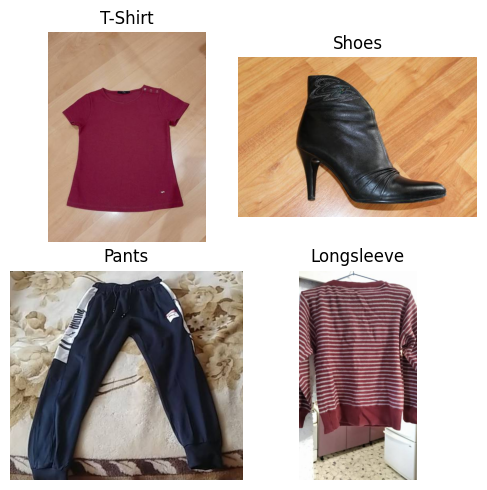

In [9]:
plt.figure(figsize=(5, 5))

for i, (label, img_path) in enumerate(image_files.items()):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Normalizacion de datos para el entrenamiento de la SVM

In [10]:
IMG_SIZE = 64  

VALID_LABELS = ['T-Shirt', 'Longsleeve', 'Pants', 'Shoes']

X = []
y = []

# Filtramos solo las clases deseadas
df_filtered = df[df['label'].isin(VALID_LABELS)]

for _, row in df_filtered.iterrows():
    img_file = os.path.join(IMAGE_PATH, row['image'] + ".jpg")
    
    img = cv2.imread(img_file)
    if img is None:
        continue
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0              # Normalización
    img = img.flatten()            # 64x64x3 → 12288
    
    X.append(img)
    y.append(row['label'])
X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)

### Division de los datos para train/test

In [11]:
print(le.classes_)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

['Longsleeve' 'Pants' 'Shoes' 'T-Shirt']


In [12]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [13]:
svm = SVC(
    kernel='linear',
    C=10, 
    gamma='scale',
    class_weight='balanced', 
    probability=True
)

svm.fit(X_train_pca, y_train)

,C,10
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [ ]:
y_pred = svm.predict(X_test_pca)

In [ ]:
background = shap.sample(X_train_pca, 50)

In [ ]:
explainer = shap.KernelExplainer(
    svm.predict_proba,
    background
)


In [ ]:
X_explain = X_test_pca[:10]
shap_values = explainer.shap_values(X_explain)


100%|██████████| 10/10 [10:12<00:00, 61.22s/it]


In [ ]:
shap_values.shape

(10, 617, 4)

In [ ]:
X_explain.shape

(10, 617)

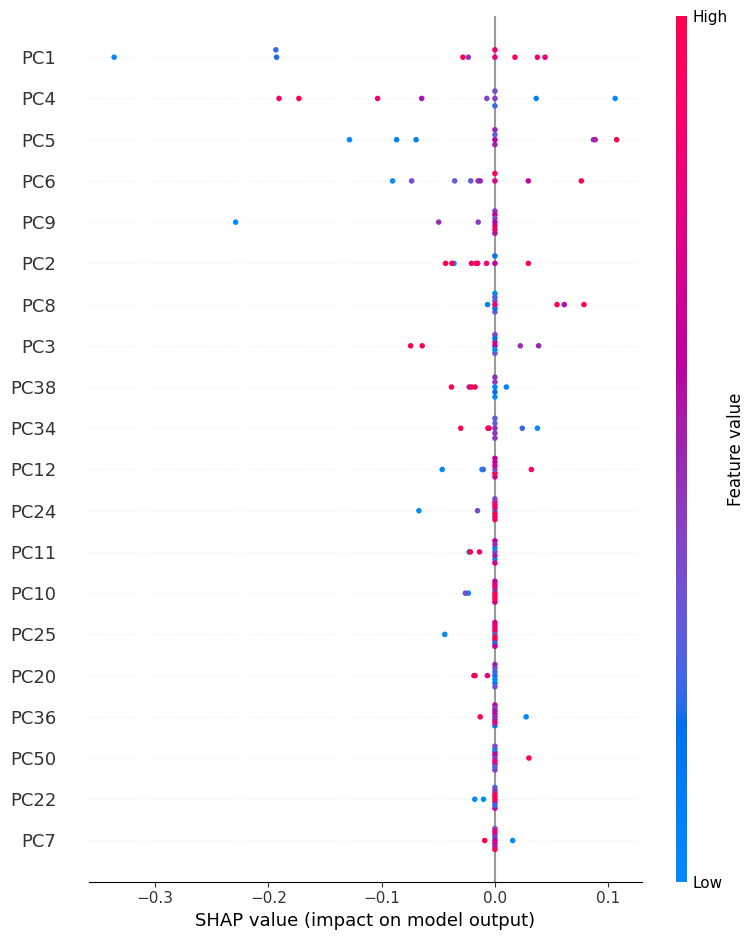

In [ ]:
class_idx = le.transform(['Pants'])[0]

shap.summary_plot(
    shap_values[:, :, class_idx],
    X_explain,
    feature_names=[f'PC{i+1}' for i in range(X_explain.shape[1])]
)


In [14]:
img = cv2.imread("Longsleeve.jpeg")
imgOrg = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = imgOrg / 255.0
img = img.flatten()
a = img.reshape(1,-1)
pca_img = pca.transform(scaler.transform(img.reshape(1, -1)))
probas = svm.predict_proba(pca_img)

In [ ]:
pred_idx = np.argmax(probas)

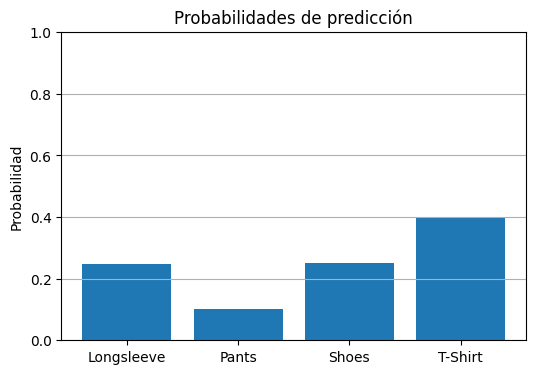

In [17]:
plt.figure(figsize=(6,4))
plt.bar(le.classes_, probas[0])
plt.title("Probabilidades de predicción")
plt.ylabel("Probabilidad")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()


array([[0.88130081, 0.88130081, 0.88130081, ..., 0.88130081, 0.88130081,
        0.88130081],
       [0.88130081, 0.88130081, 0.88130081, ..., 0.88130081, 0.88130081,
        0.88130081],
       [0.88130081, 0.88130081, 0.88130081, ..., 0.88130081, 0.88130081,
        0.88130081],
       ...,
       [0.88130081, 0.88130081, 0.88130081, ..., 0.88130081, 0.88130081,
        0.88130081],
       [0.88130081, 0.88130081, 0.88130081, ..., 0.88130081, 0.88130081,
        0.88130081],
       [0.88130081, 0.88130081, 0.88130081, ..., 0.88130081, 0.88130081,
        0.88130081]])

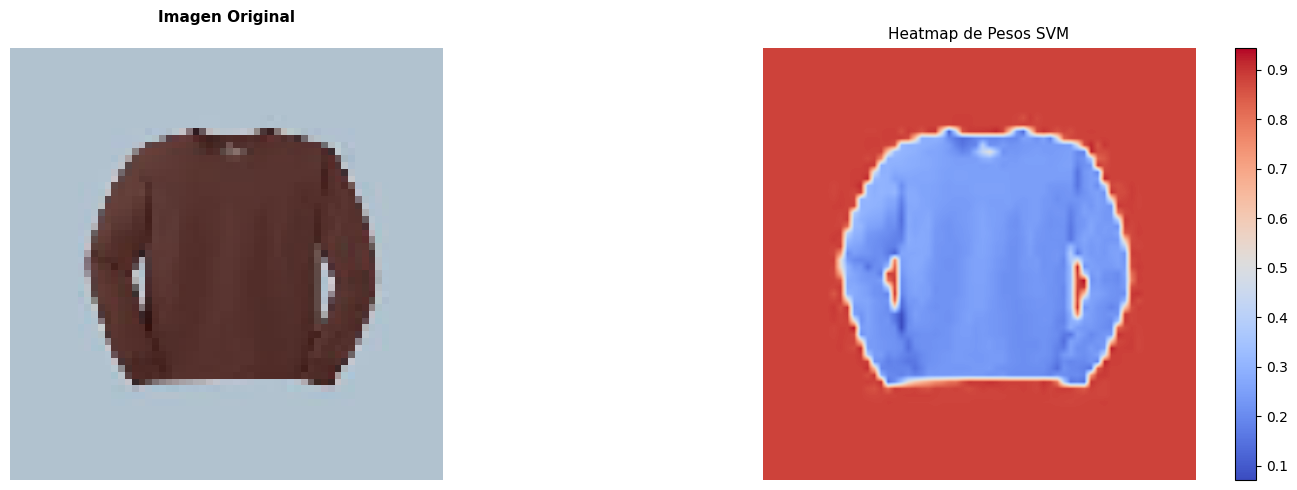

In [ ]:
def explicar_con_pesos_svm(img, img_flat, svm_model, title=""):
    
    importancia = img_flat.copy()
    
    # Reshape a imagen
    importancia_img = importancia.reshape(64, 64, 3)
    
    # Normalizar para visualización
    importancia_abs = np.abs(importancia_img)
    importancia_norm = (importancia_abs - importancia_abs.min()) / (importancia_abs.max() - importancia_abs.min() + 1e-10)
    
    # Crear heatmap (promedio de canales)
    heatmap = np.mean(importancia_norm, axis=2)
    
    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f"Imagen Original\n{title}", fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    im = axes[1].imshow(heatmap, cmap='coolwarm', interpolation='bilinear')
    axes[1].set_title("Heatmap de Pesos SVM", fontsize=11)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    plt.tight_layout()
    return heatmap
explicar_con_pesos_svm(img=imgOrg,img_flat=a,svm_model=svm)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.8253968253968254
              precision    recall  f1-score   support

  Longsleeve       0.72      0.86      0.79       140
       Pants       0.93      0.82      0.87       139
       Shoes       0.78      0.70      0.74        86
     T-Shirt       0.86      0.86      0.86       202

    accuracy                           0.83       567
   macro avg       0.82      0.81      0.81       567
weighted avg       0.83      0.83      0.83       567



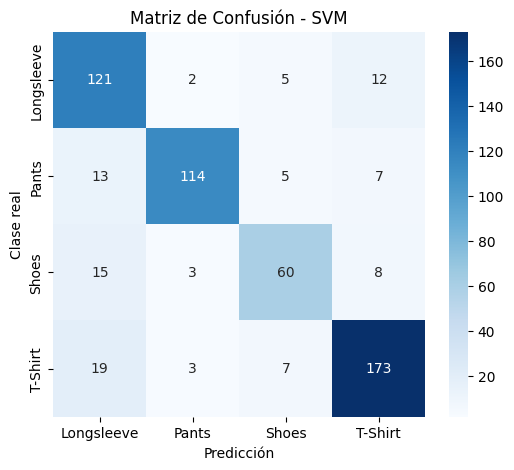

In [ ]:
class_names = le.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de Confusión - SVM")
plt.show()


In [ ]:
def predict_image_SVM (img):
    img = cv2.imread(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = img.flatten()

    pca_img = pca.transform(scaler.transform(img.reshape(1, -1)))
    pred = svm.predict(pca_img)
    
    return le.inverse_transform(pred)[0]

In [ ]:
predict_image_SVM("camiseta.png")

'T-Shirt'

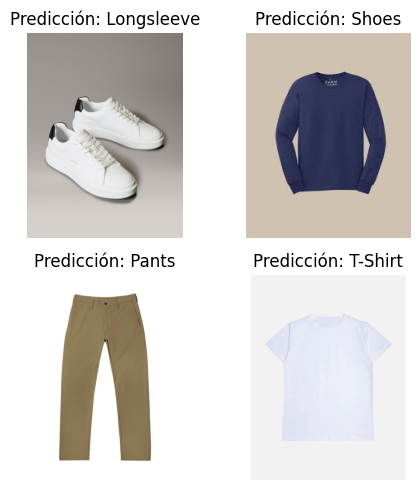

['Longsleeve', 'Shoes', 'Pants', 'T-Shirt']


In [ ]:
listImg = ["shoes.jpg", "Longsleeve.jpeg", "Pants.jpg", "camiseta.png"]
listPredicSVM = []

for img in listImg:
    listPredicSVM.append(predict_image_SVM(img))

plt.figure(figsize=(5, 5))

for i in range(len(listImg)):
    img = plt.imread(listImg[i])
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"Predicción: {listPredicSVM[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(listPredicSVM)

# CNN


In [18]:
X = []
y = []

df_filtered = df[df['label'].isin(VALID_LABELS)]

for _, row in df_filtered.iterrows():
    img_file = os.path.join(IMAGE_PATH, row['image'] + ".jpg")
    img = cv2.imread(img_file)

    if img is None:
        continue

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0 

    X.append(img)
    y.append(row['label'])

X = np.array(X)

le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [19]:
num_classes = y.shape[1]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])


2026-01-05 12:39:06.205013: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-05 12:39:06.285817: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
57/57 [==============================] - 2s 32ms/step - loss: 1.1900 - accuracy: 0.4691 - val_loss: 0.9037 - val_accuracy: 0.6322
Epoch 2/10
57/57 [==============================] - 2s 30ms/step - loss: 0.8032 - accuracy: 0.6777 - val_loss: 0.6626 - val_accuracy: 0.7401
Epoch 3/10
57/57 [==============================] - 2s 29ms/step - loss: 0.5809 - accuracy: 0.7710 - val_loss: 0.4584 - val_accuracy: 0.8392
Epoch 4/10
57/57 [==============================] - 2s 29ms/step - loss: 0.4341 - accuracy: 0.8477 - val_loss: 0.4301 - val_accuracy: 0.8414
Epoch 5/10
57/57 [==============================] - 2s 30ms/step - loss: 0.3610 - accuracy: 0.8709 - val_loss: 0.3775 - val_accuracy: 0.8590
Epoch 6/10
57/57 [==============================] - 2s 29ms/step - loss: 0.2950 - accuracy: 0.8940 - val_loss: 0.3911 - val_accuracy: 0.8414
Epoch 7/10
57/57 [==============================] - 2s 29ms/step - loss: 0.2433 - accuracy: 0.9073 - val_loss: 0.3597 - val_accuracy: 0.8767
Epoch 8/10
57

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy test: {test_acc:.2f}")

18/18 [==============================] - 0s 6ms/step - loss: 0.3166 - accuracy: 0.8924
Accuracy test: 0.89


In [23]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

18/18 [==============================] - 0s 6ms/step


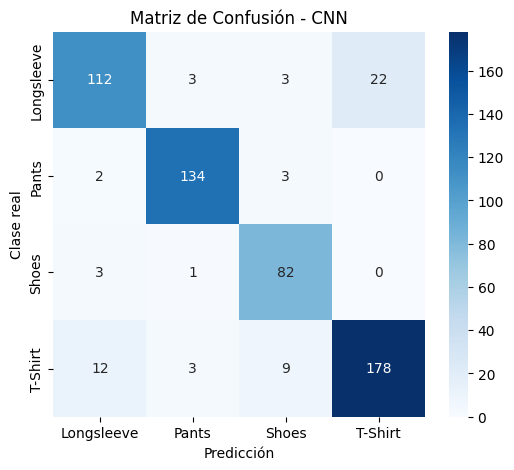

In [24]:
class_names = le.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de Confusión - CNN")
plt.show()


In [25]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

Accuracy: 0.892416225749559
              precision    recall  f1-score   support

  Longsleeve       0.87      0.80      0.83       140
       Pants       0.95      0.96      0.96       139
       Shoes       0.85      0.95      0.90        86
     T-Shirt       0.89      0.88      0.89       202

    accuracy                           0.89       567
   macro avg       0.89      0.90      0.89       567
weighted avg       0.89      0.89      0.89       567



In [26]:
def predict_image_CNN(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)
    class_idx = np.argmax(pred)

    return le.inverse_transform([class_idx])[0]

1/1 [==============================] - 0s 12ms/step


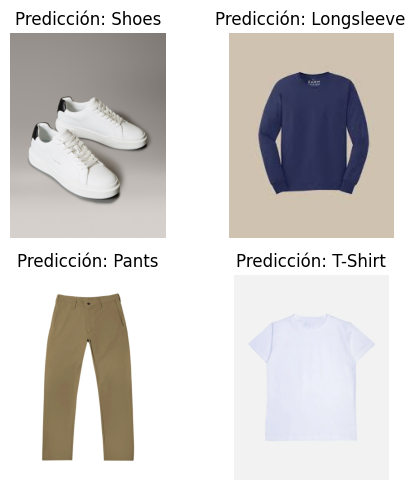

In [27]:
listImg = ["shoes.jpg", "Longsleeve.jpeg", "Pants.jpg", "camiseta.png"]
listPredicx = []
for img in listImg:
    listPredicx.append(predict_image_CNN(img))

plt.figure(figsize=(5, 5))

for i in range(len(listImg)):
    img = plt.imread(listImg[i])
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"Predicción: {listPredicx[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [30]:
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [43]:
idx = 23
img = X_test[idx]
img_input = np.expand_dims(img, axis=0)

heatmap = grad_cam(
    model,
    img_input,
    layer_name="conv2d_2"  # última capa convolucional
)


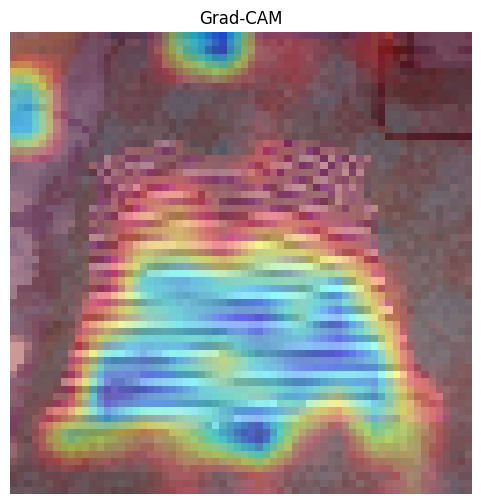

In [44]:
heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed = cv2.addWeighted(
    np.uint8(img * 255),
    0.6,
    heatmap,
    0.4,
    0
)

plt.figure(figsize=(6,6))
plt.imshow(superimposed)
plt.axis("off")
plt.title("Grad-CAM")
plt.show()
